# ARIMA Fitting: Daily Female Births in California in 1959
## (Week 5)

In [38]:
# install.packages("remotes")
# remotes::install_github("FinYang/tsdl")
library(tsdl)
library(astsa)

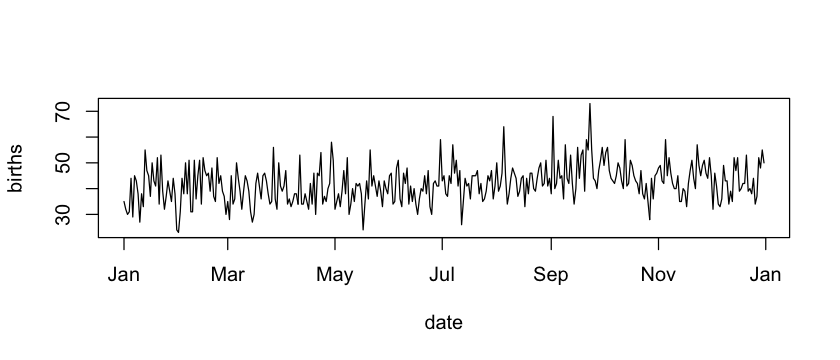

In [178]:
tsdl_subset <- subset(tsdl, description="Daily total female births in California, 1959")
time_series <- tsdl_subset[[1]]

births <- c(time_series)
date <- c(time(time_series))*365 + as.Date('01/01/1959', '%d/%m/%Y')
data <- data.frame(date=date, births=births)

options(repr.plot.width=7, repr.plot.height=3)
plot(data, type='l')

In [179]:
# Q statistic
Box.test(data$births, lag = log(length(data$births)))


	Box-Pierce test

data:  data$births
X-squared = 36.391, df = 5.8999, p-value = 2.088e-06


As p-value is very small, we reject the null hypothesis that autocorrelation coefficients are all 0 until lag 5.8999

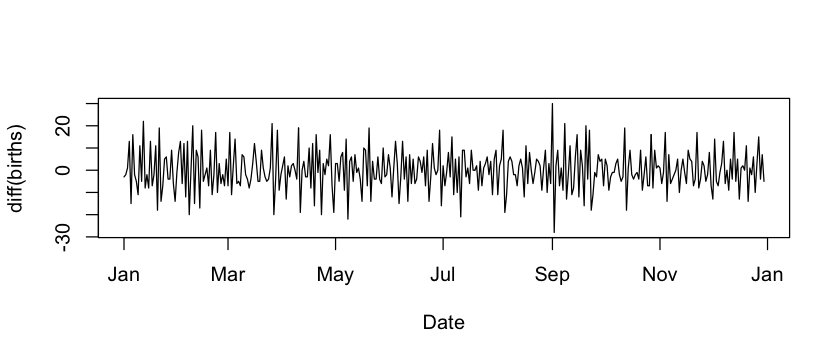

In [182]:
# Removing trend with diff
plot(diff(data$births) ~ data$date[1:364], type='l', xlab="Date", ylab="diff(births)")

Ignoring the outlier in september (attribute it to randomness) we can say we have a roughly stationary time series

In [184]:
# Q statistic for diff(births)
Box.test(diff(data$births), lag = log(length(diff(data$births))))


	Box-Pierce test

data:  diff(data$births)
X-squared = 78.094, df = 5.8972, p-value = 7.661e-15


p-value is very small, so we can say we have autocorrelation

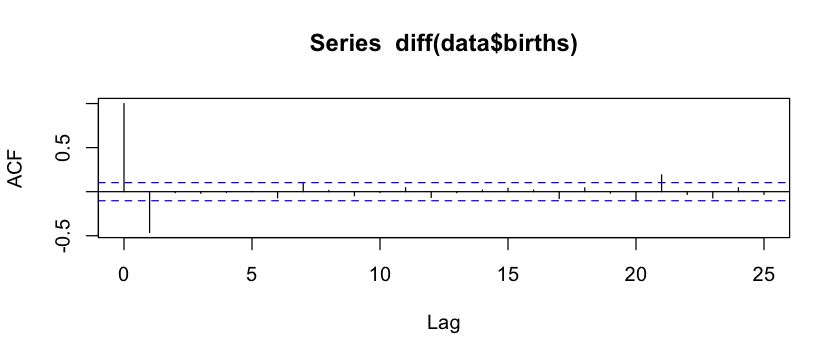

In [185]:
# Autocorrelation suggests order for moving average process
# We see a significative peak at lag 1
# there is also a significative peak at lag 21, but lets attribute it to randomness
acf(diff(data$births))

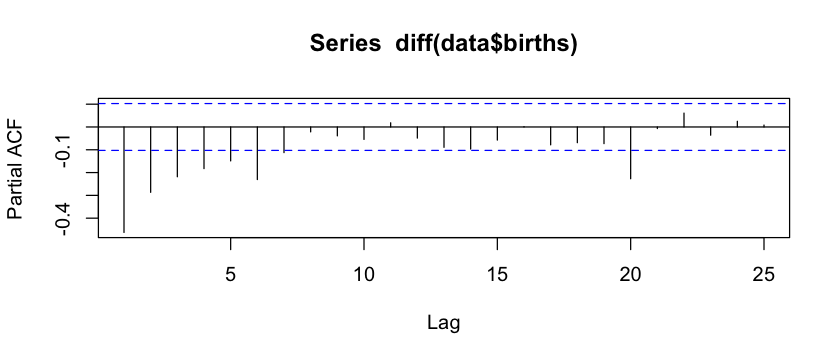

In [186]:
# suggests order for the autoregressive process
#significant peks until lag 7
pacf(diff(data$births))

## Testing models

In [188]:
model1 <- arima(data$births, order=c(0,1,1))
SSE1 <- sum(model1$residuals^2)
model1_test <- Box.test(model1$residuals, lag = log(length(model1$residuals)))

In [189]:
model2 <- arima(data$births, order=c(0,1,2))
SSE2 <- sum(model2$residuals^2)
model2_test <- Box.test(model2$residuals, lag = log(length(model2$residuals)))

In [190]:
model3 <- arima(data$births, order=c(7,1,1))
SSE3 <- sum(model3$residuals^2)
model3_test <- Box.test(model3$residuals, lag = log(length(model3$residuals)))

In [191]:
model4 <- arima(data$births, order=c(7,1,2))
SSE4 <- sum(model4$residuals^2)
model4_test <- Box.test(model4$residuals, lag = log(length(model4$residuals)))

In [194]:
df <- data.frame(row.names=c('AIC', 'SSE', 'p-value'), 
                 c(model1$aic, SSE1, model1_test$p.value),
                 c(model2$aic, SSE2, model2_test$p.value), 
                 c(model3$aic, SSE3, model3_test$p.value), 
                 c(model4$aic, SSE4, model4_test$p.value))

colnames(df) <- c('Arima(0,1,1)', 'Arima(0,1,2)', 'Arima(7,1,1)', 'Arima(7,1,2)')

In [196]:
options(scipen=999)
df

,"Arima(0,1,1)","Arima(0,1,2)","Arima(7,1,1)","Arima(7,1,2)"
AIC,2462.2207021,2459.5705306,2464.8827225,2466.6664136
SSE,18148.4561632,17914.6513437,17584.3902548,17574.0578105
p-value,0.5333604,0.9859227,0.9999899,0.9999929


If we want to get the simplest model possible (which is good, as occam's razor tells us), then we go with the smallest AIC (even though it does not have the smallest SSE).

initial  value 2.216721 
iter   2 value 2.047518
iter   3 value 1.974780
iter   4 value 1.966955
iter   5 value 1.958906
iter   6 value 1.952299
iter   7 value 1.951439
iter   8 value 1.950801
iter   9 value 1.950797
iter  10 value 1.950650
iter  11 value 1.950646
iter  12 value 1.950638
iter  13 value 1.950635
iter  13 value 1.950635
iter  13 value 1.950635
final  value 1.950635 
converged
initial  value 1.950708 
iter   2 value 1.950564
iter   3 value 1.950290
iter   4 value 1.950196
iter   5 value 1.950185
iter   6 value 1.950185
iter   7 value 1.950185
iter   7 value 1.950185
iter   7 value 1.950185
final  value 1.950185 
converged


$fit

Call:
stats::arima(x = xdata, order = c(p, d, q), seasonal = list(order = c(P, D, 
    Q), period = S), xreg = constant, transform.pars = trans, fixed = fixed, 
    optim.control = list(trace = trc, REPORT = 1, reltol = tol))

Coefficients:
          ma1      ma2  constant
      -0.8511  -0.1113     0.015
s.e.   0.0496   0.0502     0.015

sigma^2 estimated as 49.08:  log likelihood = -1226.36,  aic = 2460.72

$degrees_of_freedom
[1] 361

$ttable
         Estimate     SE  t.value p.value
ma1       -0.8511 0.0496 -17.1448  0.0000
ma2       -0.1113 0.0502  -2.2164  0.0273
constant   0.0150 0.0150   1.0007  0.3176

$AIC
[1] 6.760225

$AICc
[1] 6.760408

$BIC
[1] 6.803051


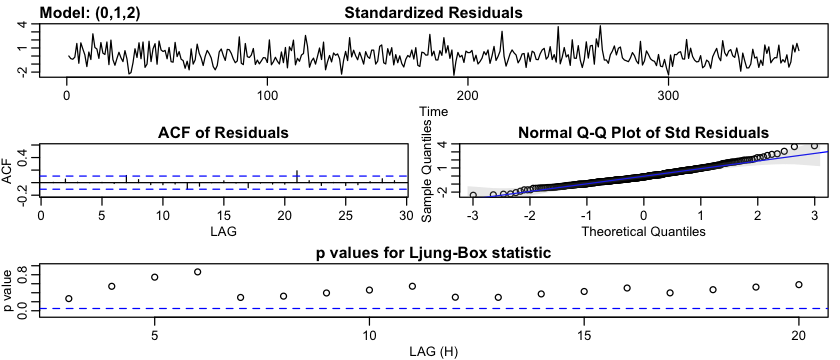

In [198]:
# fit choosen model with sarima routine from astsa package
sarima(data$births, 0, 1, 2, 0, 0, 0)

Writing down the equation for our model, we get (indices are standard errors):

$$(1-B)X_t=0.015_{0.015} + Z_t - 0.8511_{0.0496}Z_{t-1} -0.1113_{0.0502}Z_{t-2}$$

or

$$X_t= X_{t-1} + 0.015 + Z_t - 0.8511Z_{t-1} -0.1113Z_{t-2}$$

Where

$$Z_t \sim Normal(0, 49.08)$$

